In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from math import radians,cos,sqrt

In [2]:
df = pd.read_csv("Arrest_Data_from_2010_to_Present.csv")

In [3]:
#considering data only prior to Jan 1, 2019
df["arrest_year"] = df['Arrest Date'].str[-4:]
df['arrest_month'] = df['Arrest Date'].str[:2]
df['arrest_day'] = df['Arrest Date'].str[3:5]
df = df[df.arrest_year != '2019']

In [4]:
#How many bookings of arrestees were made in 2018?
df['Arrest Date'].str[-4:].value_counts(dropna=False).sort_index()

2010    162416
2011    157638
2012    163313
2013    152673
2014    139380
2015    126154
2016    118125
2017    107651
2018    104277
Name: Arrest Date, dtype: int64

In [5]:
#How many bookings of arrestees were made in the area with the most arrests in 2018?
df[df['arrest_year'] == '2018']['Area ID'].value_counts(dropna=False).values[0]

10951

In [6]:
#What is the 95% quantile of the age of the arrestee in 2018?
df_2018 = df[df.arrest_year == '2018']
df_RBVR = df_2018[df_2018['Charge Group Description'].str.contains('Robbery|Burglary|Vehicle Theft|Receive Stolen Property', na=False)]
np.percentile(df_RBVR['Age'], 95)

52.0

In [7]:
#Report the largest absolute value among the calculated Z-scores
df_zscore = df_2018[~(df_2018['Charge Group Description'].str.contains('Pre-Delinquency|Non-Criminal Detention', na=False))]
df_zscore = df_zscore[df_zscore['Charge Group Description'].notnull()]

charge_groups = df_zscore['Charge Group Code'].value_counts(dropna = False).sort_index().index

charge_age = []
for i in range(1 , len(charge_groups)+1):
    charge_age.append(np.mean(df_zscore[df_zscore['Charge Group Code'] == i].Age))

res = [abs(x-np.mean(charge_age))/np.std(charge_age) for x in charge_age]
res.sort(reverse=True)
res[0]

2.171748157656722

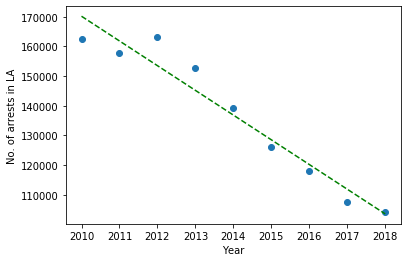

Predicted number of arrests in 2019: 95229.7777777724


In [8]:
#What is the projected number of felony arrests in 2019?
arrest_counts = df['arrest_year'].value_counts(dropna=False).sort_index()
years = arrest_counts.index.astype(int)
counts = arrest_counts.values.astype(int)

data = {'Years':years, 'Counts':counts}
df_arrests = pd.DataFrame(data)

x=data['Years']
y=data['Counts']
plt.scatter(x,y)
m = np.poly1d(np.polyfit(x, y, 1))
plt.plot(x,m(x),"g--")
plt.xlabel('Year')
plt.ylabel('No. of arrests in LA')

plt.show()

print('Predicted number of arrests in 2019: ' + str(m[1]*2019 + m[0]))

In [9]:
#How many arrest incidents occurred within 2 km from the Bradbury Building in 2018? Use (34.050536, -118.247861) for the coordinates of the Bradbury Building
def distance_checker(m):
    m = m[1:-2].split(', ')
    m = [ float(x) for x in m ]
    lat1 = radians(34.050536)
    lon1 = radians(-118.247861)
    lat2 = radians(m[0])
    lon2 = radians(m[1])
    
    R = 6371  #radius of the earth in km
    x = (lon2 - lon1) * cos( 0.5*(lat2+lat1) )
    y = lat2 - lat1
    d = R * sqrt( x*x + y*y )
    
    if d < 2:
        return d

df_2018[df_2018.Location.apply(distance_checker)<2].shape[0]

11494

In [10]:
#How many arrest incidents were made per kilometer on Pico Boulevard during 2018?
temploc = df_2018['Location'].values
ReportID = df_2018['Report ID'].values
latitude = []
longitude = []
for i in temploc:
    latitude.append(float(i[1:i.index(', ')]))
    longitude.append(float(i[i.index(', ')+2:-1]))

latlong = {'Report ID': ReportID, 'latitude':latitude, 'longitude':longitude}
df_latlong = pd.DataFrame(latlong)
#df_2018_temp = df_2018
df_2018 = pd.merge(left=df_latlong, right=df_2018, on=None, left_on='Report ID', right_on='Report ID')

def pico(x):
    if 'PICO' in x.upper():
        return x

df_pico = df_2018[df_2018.Address.apply(pico).notnull()]
df_pico.head()

minlat = np.mean(df_pico.latitude)- 2*np.std(df_pico.latitude)
maxlat = np.mean(df_pico.latitude)+ 2*np.std(df_pico.latitude)
minlong = np.mean(df_pico.longitude)- 2*np.std(df_pico.longitude)
maxlong = np.mean(df_pico.longitude)+ 2*np.std(df_pico.longitude)

df_pico = df_pico[df_pico.latitude>minlat]
df_pico = df_pico[df_pico.latitude<maxlat]
df_pico = df_pico[df_pico.longitude>minlong]
df_pico = df_pico[df_pico.longitude<maxlong]

latitude = df_pico['latitude'].values
longitude = df_pico['longitude'].values

def distance(m1, m2, n1, n2):
    lat1 = radians(m1)
    lon1 = radians(m2)
    lat2 = radians(n1)
    lon2 = radians(n2)
    
    R = 6371  #radius of the earth in km
    x = (lon2 - lon1) * cos( 0.5*(lat2+lat1) )
    y = lat2 - lat1
    d = R * sqrt( x*x + y*y )
    
    return d

def max_distance():
    k = 0
    cordinates = [0,0,0,0]
    for i in range(len(latitude)):
        for j in range(i + 1, len(latitude)):
            if (latitude[i]!=0 and longitude[i]!=0 and latitude[j]!=0 and longitude[j]!=0):
                h = distance(latitude[i], longitude[i], latitude[j], longitude[j])
                if h > k:
                    k = h 
                    cordinates = [latitude[i], longitude[i], latitude[j], longitude[j]]
                    
    return k, cordinates

k, cordinates = max_distance()
print('Furthest cordinates in Pico Boulevard are: (' + str(cordinates[0]) + ', ' + str(cordinates[1]) + ') and (' + str(cordinates[2]) + ', ' + str(cordinates[3]) + ') with distance: ' + str(k) + ' km')
print('Number of arrest incidents per kilometer on Pico Boulevard in 2018: ' + str(df_pico.shape[0]/k))

Furthest cordinates in Pico Boulevard are: (34.0281, -118.453) and (34.0188, -118.2159) with distance: 21.875430097186925 km
Number of arrest incidents per kilometer on Pico Boulevard in 2018: 27.656599084550116


In [11]:
#Report the average of the top 5 of the calculated ratio.
df = df[df['Charge Group Code'].notnull()]
df = df[df['Charge Group Code'] != 99]

city_charges = df['Charge Group Code'].value_counts(dropna=False).sort_index().values
ratios = []
for i in range(1,22):
    dfarea = df[df['Area ID'] == i]
    area_charges = dfarea['Charge Group Code'].value_counts(dropna=False).sort_index().values
    
    for j in range(len(area_charges)):
        n = area_charges[j]/dfarea.shape[0]
        m = city_charges[j]/df.shape[0]
        ratios.append(n/m)
        #print(n/m, j, i)
        
ratios.sort(reverse=True)
np.mean(ratios[0:5])

3.515076379865202